# Bond Pricing and Risk Metrics

Fixed income analytics: pricing, duration, convexity, DV01.

In [11]:
import sys
sys.path.append('..')

from ficc.bonds import (
    price_bond,
    calculate_duration,
    calculate_convexity,
    calculate_dv01,
    bond_analytics,
    price_change_estimate
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)

## 1. Bond Pricing

Bond price via present value:

$$P = \sum_{t=1}^{n} \frac{C}{(1+y)^t} + \frac{F}{(1+y)^n}$$

where $C$ is coupon payment, $F$ is face value, $y$ is yield per period, $n$ is number of periods.

In [12]:
# Par, premium, discount bonds
par = price_bond(100, 0.05, 0.05, 5, 2)
premium = price_bond(100, 0.05, 0.03, 5, 2)
discount = price_bond(100, 0.05, 0.07, 5, 2)

pd.DataFrame([par, premium, discount], index=['Par', 'Premium', 'Discount'])

,price,dirty_price,discount_premium,par_yield_diff
Par,100.00,100.00,0.00,0.0
Premium,109.22,109.22,9.22,200.0
Discount,91.68,91.68,-8.32,-200.0


## 2. Price-Yield Relationship

Inverse and convex relationship between price and yield.

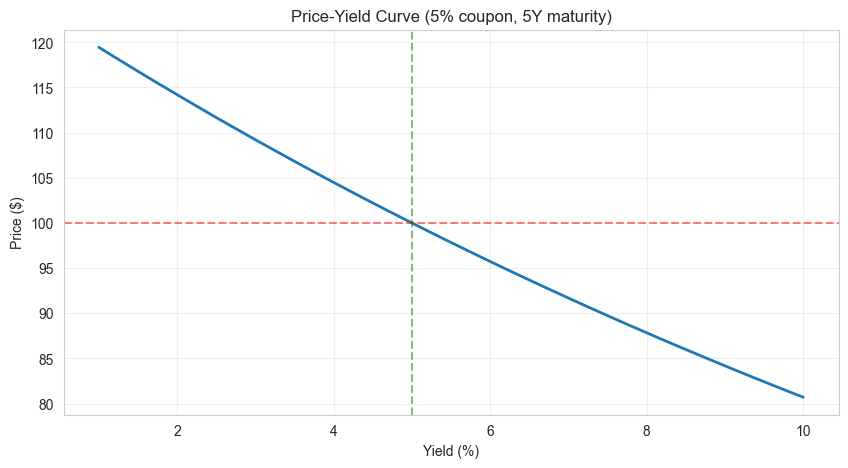

In [13]:
yields = np.linspace(0.01, 0.10, 50)
prices = [price_bond(100, 0.05, y, 5, 2)['price'] for y in yields]

plt.figure(figsize=(10, 5))
plt.plot(yields * 100, prices, linewidth=2)
plt.axhline(y=100, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=5, color='g', linestyle='--', alpha=0.5)
plt.xlabel('Yield (%)')
plt.ylabel('Price ($)')
plt.title('Price-Yield Curve (5% coupon, 5Y maturity)')
plt.grid(alpha=0.3)
plt.show()

## 3. Duration

**Macaulay Duration**: Weighted average time to cash flows

$$D_{Mac} = \frac{1}{P} \sum_{t=1}^{n} t \cdot \frac{CF_t}{(1+y)^t}$$

**Modified Duration**: Price sensitivity to yield

$$D_{Mod} = \frac{D_{Mac}}{1+y}$$

Approximation: $\Delta P \approx -D_{Mod} \cdot P \cdot \Delta y$

In [14]:
duration = calculate_duration(100, 0.05, 0.05, 5, 2)
pd.Series(duration)

macaulay_duration          4.4854
modified_duration          4.3760
approx_price_change_1bp   -0.0438
dtype: float64

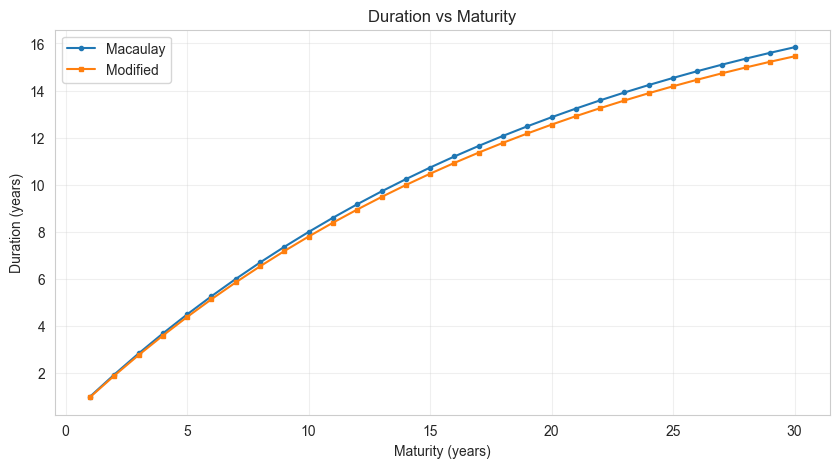

In [15]:
# Duration vs maturity
maturities = range(1, 31)
mac_durations = [calculate_duration(100, 0.05, 0.05, float(m), 2)['macaulay_duration'] for m in maturities]
mod_durations = [calculate_duration(100, 0.05, 0.05, float(m), 2)['modified_duration'] for m in maturities]

plt.figure(figsize=(10, 5))
plt.plot(maturities, mac_durations, label='Macaulay', marker='o', markersize=3)
plt.plot(maturities, mod_durations, label='Modified', marker='s', markersize=3)
plt.xlabel('Maturity (years)')
plt.ylabel('Duration (years)')
plt.title('Duration vs Maturity')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 4. Convexity

Second-order price sensitivity:

$$C = \frac{1}{P} \sum_{t=1}^{n} \frac{t(t+1) \cdot CF_t}{(1+y)^{t+2}}$$

Taylor approximation:

$$\Delta P \approx -D_{Mod} \cdot P \cdot \Delta y + \frac{1}{2} C \cdot P \cdot (\Delta y)^2$$

In [16]:
convexity = calculate_convexity(100, 0.05, 0.05, 5, 2)
pd.Series(convexity)

convexity                   22.612300
convexity_adjustment_1bp     0.000011
dtype: float64

## 5. DV01

Dollar value of one basis point:

$$DV01 = |P(y) - P(y + 0.0001)|$$

In [ ]:
dv01 = calculate_dv01(100, 0.05, 0.05, 5, 2)
pd.Series(dv01)

## 6. Multiple Metrics

In [17]:
analytics = bond_analytics(100, 0.05, 0.05, 5, 2)
pd.DataFrame([analytics]).T

,0
price,100.000000
dirty_price,100.000000
discount_premium,0.000000
par_yield_diff,0.000000
macaulay_duration,4.485400
modified_duration,4.376000
approx_price_change_1bp,-0.043800
convexity,22.612300
convexity_adjustment_1bp,0.000011
dv01,0.040000


## 7. Price Change Estimation

Test duration/convexity approximation accuracy for different yield shifts.

In [18]:
yield_changes = [-0.02, -0.01, -0.005, 0.005, 0.01, 0.02]
results = []

for dy in yield_changes:
    est = price_change_estimate(100, 0.05, 0.05, 5, dy, 2, True)
    results.append({
        'Δy (bp)': dy * 10000,
        'Actual Price': est['actual_new_price'],
        'Est. Price': est['estimated_new_price'],
        'Error': est['estimation_error'],
        'Duration Effect': est['duration_effect'],
        'Convexity Effect': est['convexity_effect']
    })

pd.DataFrame(results)

,Δy (bp),Actual Price,Est. Price,Error,Duration Effect,Convexity Effect
0,-200.0,109.22,109.20,-0.0158,8.75,0.4522
1,-100.0,104.49,104.49,-0.0009,4.38,0.1131
2,-50.0,102.22,102.22,-0.0037,2.19,0.0283
3,50.0,97.84,97.84,0.0003,-2.19,0.0283
4,100.0,95.73,95.74,0.0071,-4.38,0.1131
5,200.0,91.68,91.70,0.0202,-8.75,0.4522


## 8. Bond Comparison

In [19]:
bonds = [
    {'name': '2Y 3%', 'coupon': 0.03, 'maturity': 2, 'yield': 0.04},
    {'name': '5Y 5%', 'coupon': 0.05, 'maturity': 5, 'yield': 0.05},
    {'name': '10Y 4%', 'coupon': 0.04, 'maturity': 10, 'yield': 0.045},
    {'name': '30Y 6%', 'coupon': 0.06, 'maturity': 30, 'yield': 0.05},
]

comparison = []
for bond in bonds:
    a = bond_analytics(100, bond['coupon'], bond['yield'], bond['maturity'], 2)
    comparison.append({
        'Bond': bond['name'],
        'Price': a['price'],
        'Mac Dur': a['macaulay_duration'],
        'Mod Dur': a['modified_duration'],
        'Convexity': a['convexity'],
        'DV01': a['dv01']
    })

pd.DataFrame(comparison)

,Bond,Price,Mac Dur,Mod Dur,Convexity,DV01
0,2Y 3%,98.10,1.9555,1.9172,4.6637,0.02
1,5Y 5%,100.00,4.4854,4.3760,22.6123,0.04
2,10Y 4%,96.01,8.2977,8.1151,78.0045,0.08
3,30Y 6%,115.45,15.2838,14.9110,331.6703,0.17


## 9. Zero-Coupon Bond

For zero-coupon: $D_{Mac} = T$ (maturity)

In [20]:
zero = bond_analytics(100, 0.0, 0.05, 5, 2)
print(f"Price: ${zero['price']:.2f}")
print(f"Macaulay Duration: {zero['macaulay_duration']:.4f} years (Maturity: 5.0)")
print(f"Match: {abs(zero['macaulay_duration'] - 5.0) < 0.01}")

Price: $78.12
Macaulay Duration: 5.0000 years (Maturity: 5.0)
Match: True


## 10. Portfolio Rate Shock

Example: 50bp rate increase impact on portfolio.

In [21]:
portfolio = [
    {'name': '2Y Treasury', 'face': 10, 'coupon': 0.04, 'yield': 0.04, 'maturity': 2},
    {'name': '10Y Treasury', 'face': 15, 'coupon': 0.045, 'yield': 0.045, 'maturity': 10},
    {'name': '30Y Treasury', 'face': 5, 'coupon': 0.05, 'yield': 0.05, 'maturity': 30},
]

rate_shock = 0.005
pnl_data = []

for bond in portfolio:
    current = bond_analytics(100, bond['coupon'], bond['yield'], bond['maturity'], 2)
    new_price = price_bond(100, bond['coupon'], bond['yield'] + rate_shock, bond['maturity'], 2)['price']
    
    current_value = current['price'] * bond['face'] * 10000
    new_value = new_price * bond['face'] * 10000
    pnl = new_value - current_value
    
    pnl_data.append({
        'Bond': bond['name'],
        'Face ($MM)': bond['face'],
        'Mod Dur': current['modified_duration'],
        'Current Price': current['price'],
        'New Price': new_price,
        'P&L ($)': pnl
    })

df_pnl = pd.DataFrame(pnl_data)
print(df_pnl.to_string(index=False))
print(f"\nTotal P&L: ${df_pnl['P&L ($)'].sum():,.0f}")

        Bond  Face ($MM)  Mod Dur  Current Price  New Price   P&L ($)
 2Y Treasury          10   1.9039          100.0      99.05  -95000.0
10Y Treasury          15   7.9819          100.0      96.10 -585000.0
30Y Treasury           5  15.4543          100.0      92.69 -365500.0

Total P&L: $-1,045,500
